# Основы глубинного обучения, майнор ИАД

## Домашнее задание 1. Введение в PyTorch. Полносвязные нейронные сети.

### Общая информация

Дата выдачи: 06.10.2021

Мягкий дедлайн: 23:59MSK 25.10.2021

Жесткий дедлайн: 23:59MSK 28.10.2021

### Оценивание и штрафы
Максимально допустимая оценка за работу — 10 баллов. За каждый день просрочки снимается 1 балл. Сдавать задание после жёсткого дедлайна сдачи нельзя.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.
Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

### О задании

В этом задании вам предстоит предсказывать год выпуска песни по некоторым звуковым признакам: [данные](https://archive.ics.uci.edu/ml/datasets/yearpredictionmsd). В ячейках ниже находится код для загрузки данных. Обратите внимание, что обучающая и тестовая выборки располагаются в одном файле, поэтому НЕ меняйте ячейку, в которой производится деление данных.

In [ ]:
import torch
from torch import nn
import pandas as pd
import numpy as np
import random

In [ ]:
!wget -O data.txt.zip https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip

--2021-10-26 02:21:12--  https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 211011981 (201M) [application/x-httpd-php]
Saving to: ‘data.txt.zip’

data.txt.zip        100%[===================>] 201.24M  95.4MB/s    in 2.1s    

2021-10-26 02:21:14 (95.4 MB/s) - ‘data.txt.zip’ saved [211011981/211011981]



In [ ]:
df = pd.read_csv('data.txt.zip', header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90
0,2001,49.94357,21.47114,73.07750,8.74861,-17.40628,-13.09905,-25.01202,-12.23257,7.83089,-2.46783,3.32136,-2.31521,10.20556,611.10913,951.08960,698.11428,408.98485,383.70912,326.51512,238.11327,251.42414,187.17351,100.42652,179.19498,-8.41558,-317.87038,95.86266,48.10259,-95.66303,-18.06215,1.96984,34.42438,11.72670,1.36790,7.79444,-0.36994,-133.67852,-83.26165,-37.29765,...,-25.38187,-3.90772,13.29258,41.55060,-7.26272,-21.00863,105.50848,64.29856,26.08481,-44.59110,-8.30657,7.93706,-10.73660,-95.44766,-82.03307,-35.59194,4.69525,70.95626,28.09139,6.02015,-37.13767,-41.12450,-8.40816,7.19877,-8.60176,-5.90857,-12.32437,14.68734,-54.32125,40.14786,13.01620,-54.40548,58.99367,15.37344,1.11144,-23.08793,68.40795,-1.82223,-27.46348,2.26327
1,2001,48.73215,18.42930,70.32679,12.94636,-10.32437,-24.83777,8.76630,-0.92019,18.76548,4.59210,2.21920,0.34006,44.38997,2056.93836,605.40696,457.41175,777.15347,415.64880,746.47775,366.45320,317.82946,273.07917,141.75921,317.35269,19.48271,-65.25496,162.75145,135.00765,-96.28436,-86.87955,17.38087,45.90742,32.49908,-32.85429,45.10830,26.84939,-302.57328,-41.71932,-138.85034,...,28.55107,1.52298,70.99515,-43.63073,-42.55014,129.82848,79.95420,-87.14554,-45.75446,-65.82100,-43.90031,-19.45705,12.59163,-407.64130,42.91189,12.15850,-88.37882,42.25246,46.49209,-30.17747,45.98495,130.47892,13.88281,-4.00055,17.85965,-18.32138,-87.99109,14.37524,-22.70119,-58.81266,5.66812,-19.68073,33.04964,42.87836,-9.90378,-32.22788,70.49388,12.04941,58.43453,26.92061
2,2001,50.95714,31.85602,55.81851,13.41693,-6.57898,-18.54940,-3.27872,-2.35035,16.07017,1.39518,2.73553,0.82804,7.46586,699.54544,1016.00954,594.06748,355.73663,507.39931,387.69910,287.15347,112.37152,161.68928,144.14353,199.29693,-4.24359,-297.00587,-148.36392,-7.94726,-18.71630,12.77542,-25.37725,9.71410,0.13843,26.79723,6.30760,28.70107,-74.89005,-289.19553,-166.26089,...,18.50939,16.97216,24.26629,-10.50788,-8.68412,54.75759,194.74034,7.95966,-18.22685,0.06463,-2.63069,26.02561,1.75729,-262.36917,-233.60089,-2.50502,-12.14279,81.37617,2.07554,-1.82381,183.65292,22.64797,-39.98887,43.37381,-31.56737,-4.88840,-36.53213,-23.94662,-84.19275,66.00518,3.03800,26.05866,-50.92779,10.93792,-0.07568,43.20130,-115.00698,-0.05859,39.67068,-0.66345
3,2001,48.24750,-1.89837,36.29772,2.58776,0.97170,-26.21683,5.05097,-10.34124,3.55005,-6.36304,6.63016,-3.35142,37.64085,2174.08189,697.43346,459.24587,742.78961,229.30783,387.89697,249.06662,245.89870,176.20527,98.82222,150.97286,78.49057,-62.00282,43.49659,-96.42719,-108.96608,14.22854,14.54178,-23.55608,-39.36953,-43.59209,20.83714,35.63919,-181.34947,-93.66614,-90.55616,...,4.56917,-37.32280,4.15159,12.24315,35.02697,-178.89573,82.46573,-20.49425,101.78577,-19.77808,-21.52657,3.36303,-11.63176,51.55411,-50.57576,-28.14755,-83.15795,-7.35260,-22.11505,1.18279,-122.70467,150.57360,24.37468,41.19821,-37.04318,-28.72986,162.19614,22.18309,-8.63509,85.23416,34.57337,-171.70734,-16.96705,-46.67617,-12.51516,82.58061,-72.08993,9.90558,199.62971,18.85382
4,2001,50.97020,42.20998,67.09964,8.46791,-15.85279,-16.81409,-12.48207,-9.37636,12.63699,0.93609,1.60923,2.19223,47.32082,894.28471,809.86615,318.78559,435.04497,341.61467,334.30734,322.99589,190.61921,235.84715,96.89517,210.58870,5.60463,-199.63958,204.85812,-77.17695,-65.79741,-6.95097,-12.15262,-3.85410,20.68990,-20.30480,37.15045,11.20673,-124.09519,-295.98542,-33.31169,...,45.25506,10.42226,27.88782,-17.12676,-31.54772,-76.86293,41.17343,-138.32535,-53.96905,-21.30266,-24.87362,-2.46595,-4.05003,-56.51161,-34.56445,-5.07092,-47.75605,64.81513,-97.42948,-12.59418,55.23699,28.85657,54.53513,-31.97077,20.03279,-8.07892,-55.12617,26.58961,-10.27183,-30.64232,9.92661,-55.95724,64.92712,-17.72522,-1.49237,-7.50035,51.76631,7.88713,55.6

In [ ]:
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

train_size = 463715
X_train = X[:train_size, :]
y_train = y[:train_size]
X_test = X[train_size:, :]
y_test = y[train_size:]

## Задание 0. (0 баллов, но при невыполнении максимум за все задание &mdash; 0 баллов)

Мы будем использовать RMSE как метрику качества. Для самого первого бейзлайна обучите `Ridge` регрессию из `sklearn`. Кроме того, посчитайте качество при наилучшем константном прогнозе.

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

In [ ]:
rmse = []
for a in [0.1, 1, 10, 100, 200]:
  ridge = Ridge(alpha = a)
  ridge.fit(X_train, y_train)
  y_pred_a1 = ridge.predict(X_test)
  rmse.append(mean_squared_error(y_test, y_pred_a1, squared=False))

In [ ]:
print("RMSE for ridge regression:", "\na = 0.1, RMSE = {}".format(rmse[0]),
      "\na = 1, RMSE = {}".format(rmse[1]),
      "\na = 10, RMSE = {}".format(rmse[2]),
      "\na = 100, RMSE = {}".format(rmse[3]),
      "\na = 200, RMSE = {}".format(rmse[4]),
      "\nThe best one with a = {}".format([0.1, 1, 10, 100, 200][rmse.index(min(rmse))]))

RMSE for ridge regression: 
a = 0.1, RMSE = 9.510160707877098 
a = 1, RMSE = 9.510160711373395 
a = 10, RMSE = 9.510160746337895 
a = 100, RMSE = 9.510161096134519 
a = 200, RMSE = 9.510161485120747 
The best one with a = 0.1


## Задание 1. (максимум 10 баллов)

Реализуйте обучение и тестирование нейронной сети для предоставленного вам набора данных. Соотношение между полученным значением метрики на тестовой выборке и баллами за задание следующее:

- $\text{RMSE} \le 9.00 $ &mdash; 4 балла
- $\text{RMSE} \le 8.90 $ &mdash; 6 баллов
- $\text{RMSE} \le 8.80 $ &mdash; 8 баллов
- $\text{RMSE} \le 8.75 $ &mdash; 10 баллов

Есть несколько правил, которых вам нужно придерживаться:

- Весь пайплайн обучения должен быть написан на PyTorch. При этом вы можете пользоваться другими библиотеками (`numpy`, `sklearn` и пр.), но только для обработки данных. То есть как угодно трансформировать данные и считать метрики с помощью этих библиотек можно, а импортировать модели из `sklearn` и выбивать с их помощью требуемое качество &mdash; нельзя. Также нельзя пользоваться библиотеками, для которых сам PyTorch является зависимостью.

- Мы никак не ограничиваем ваш выбор архитектуры модели, но скорее всего вам будет достаточно полносвязной нейронной сети.

- Для обучения запрещается использовать какие-либо иные данные, кроме обучающей выборки.

- Ансамблирование моделей запрещено.

### Полезные советы:

- Очень вряд ли, что у вас с первого раза получится выбить качество на 10 баллов, поэтому пробуйте разные архитектуры, оптимизаторы и значения гиперпараметров. В идеале при запуске каждого нового эксперимента вы должны менять что-то одно, чтобы точно знать, как этот фактор влияет на качество.

- Тот факт, что мы занимаемся глубинным обучением, не означает, что стоит забывать про приемы, использующиеся в классическом машинном обучении. Так что обязательно проводите исследовательский анализ данных, отрисовывайте нужные графики и не забывайте про масштабирование и подбор гиперпараметров.

- Вы наверняка столкнетесь с тем, что ваша нейронная сеть будет сильно переобучаться. Для нейросетей существуют специальные методы регуляризации, например, dropout ([статья](https://jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf)) и weight decay ([блогпост](https://towardsdatascience.com/weight-decay-l2-regularization-90a9e17713cd)). Они, разумеется, реализованы в PyTorch. Попробуйте поэкспериментировать с ними.

- Если вы чего-то не знаете, не гнушайтесь гуглить. В интернете очень много полезной информации, туториалов и советов по глубинному обучению в целом и по PyTorch в частности. Но не забывайте, что за скатанный код без ссылки на источник придется ответить по всей строгости!

- Если вы сразу реализуете обучение на GPU, то у вас будет больше времени на эксперименты, так как любые вычисления будут работать быстрее. Google Colab предоставляет несколько GPU-часов (обычно около 8-10) в сутки бесплатно.

- Чтобы отладить код, можете обучаться на небольшой части данных или даже на одном батче. Если лосс на обучающей выборке не падает, то что-то точно идет не так!

- Пользуйтесь утилитами, которые вам предоставляет PyTorch (например, Dataset и Dataloader). Их специально разработали для упрощения разработки пайплайна обучения.

- Скорее всего вы захотите отслеживать прогресс обучения. Для создания прогресс-баров есть удобная библиотека `tqdm`.

- Быть может, вы захотите, чтобы графики рисовались прямо во время обучения. Можете воспользоваться функцией [clear_output](http://ipython.org/ipython-doc/dev/api/generated/IPython.display.html#IPython.display.clear_output), чтобы удалять старый график и рисовать новый на его месте.

**ОБЯЗАТЕЛЬНО** рисуйте графики зависимости лосса/метрики на обучающей и тестовой выборках в зависимости от времени обучения. Если обучение занимает относительно небольшое число эпох, то лучше рисовать зависимость от номера шага обучения, если же эпох больше, то рисуйте зависимость по эпохам. Если проверяющий не увидит такого графика для вашей лучшей модели, то он в праве снизить баллы за задание.

**ВАЖНО!** Ваше решение должно быть воспроизводимым. Если это не так, то проверяющий имеет право снизить баллы за задание. Чтобы зафиксировать random seed, воспользуйтесь функцией из ячейки ниже.



In [ ]:
def set_random_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

g = torch.Generator()
g.manual_seed(0)

In [ ]:
X_train.shape

(463715, 90)

In [ ]:
X_test.shape

(51630, 90)

In [ ]:
# Разделим года на декады для визуализаци
df['decade'] = df[0].apply(lambda year : year-(year%10))

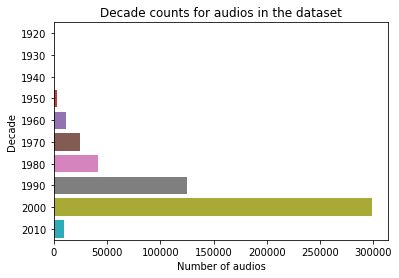

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(y='decade', data=df)
plt.xlabel("Number of audios")
plt.ylabel("Decade")
plt.title("Decade counts for audios in the dataset");

Мы видим, что большинство аудиозаписей принадлежит к годам с 2000 по 2010. Можно посмотеть подробнее, какой именно год является самым популярным:

In [ ]:
df_year = df.loc[(df[0] - df[0]%10) == 2000]

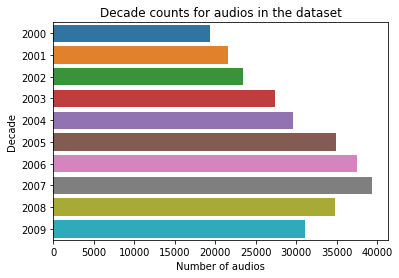

In [ ]:
sns.countplot(y=df_year[0], data=df_year)
plt.xlabel("Number of audios")
plt.ylabel("Decade")
plt.title("Decade counts for audios in the dataset");

Распределение по годам внутри декады 2000х примерно равномерное.

In [ ]:
# Видно, что распределение значений внутри параметров очень варьирует
df.iloc[:,:-1].describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90
count,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,...,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000
mean,1998.397082,43.387126,1.289554,8.658347,1.164124,-6.553601,-9.521975,-2.391089,-1.793236,3.727876,1.882385,-0.146527,2.546063,33.714006,2439.359375,1967.734202,1514.859902,910.981344,879.146721,603.737434,517.579339,393.962215,325.733170,288.885085,291.973238,43.031969,43.314873,-46.449006,-27.672783,14.958491,44.514859,5.131786,24.034309,9.498816,-4.178856,0.499475,72.652267,-51.441256,117.921056,-189.880885,...,6.378511,28.294082,12.772241,1.700474,-10.205155,64.101262,104.822085,-0.026481,38.678040,-27.989985,3.301739,0.307127,-0.478828,-138.223224,-0.696065,0.242582,3.151751,27.642745,31.822244,-0.835950,-8.931564,4.849253,-27.347646,-11.938792,-21.572137,-5.576196,-23.304324,31.113053,-104.974794,26.962393,15.755406,-73.461500,41.542422,37.934119,0.315751,17.669213,-26.315336,4.458641,20.035136,1.329105
std,10.931046,6.067558,51.580351,35.268585,16.322790,22.860785,12.857751,14.571873,7.963827,10.582861,6.530232,4.370848,8.320190,22.259632,1749.367690,1261.484792,1092.831044,475.708203,576.865994,317.499288,309.364735,214.013502,165.699383,186.960729,153.475649,121.429498,715.759147,544.879865,218.368476,163.215789,134.887832,99.088119,71.809934,74.411680,53.517036,42.490396,107.912629,415.039100,453.399231,260.645370,...,93.555672,75.049277,69.981849,83.278660,57.806591,273.827189,311.135298,266.774027,169.072163,144.083035,59.447204,49.181425,37.675424,308.187390,222.198519,128.140961,99.920949,116.696176,106.359938,36.799193,251.606754,229.060421,163.782620,63.288891,64.691545,26.358175,268.190912,144.156203,201.137522,123.847891,32.099635,175.618889,122.228799,95.050631,16.161764,114.427905,173.977336,13.346557,185.558247,22.088576
min,1922.000000,1.749000,-337.092500,-301.005060,-154.183580,-181.953370,-81.794290,-188.214000,-72.503850,-126.479040,-41.631660,-69.680870,-94.041960,0.132830,8.474200,21.214350,17.857900,12.150420,5.517710,19.808810,6.254870,6.183760,15.307500,6.116440,5.177340,-2821.430210,-13390.360690,-12017.088870,-4324.864700,-3357.279900,-3115.374560,-3805.666170,-1516.356440,-1679.118320,-1590.637130,-989.645800,-1711.484000,-8448.194880,-10095.725950,-9803.759040,...,-2270.811070,-1746.478220,-3188.177380,-2199.782210,-1694.260320,-5154.024360,-5111.601750,-4730.599100,-3756.490790,-2499.954680,-1900.104800,-1396.701680,-600.090760,-10345.833280,-7375.977440,-3896.275220,-1199.004420,-2564.788120,-1904.984320,-974.702480,-7057.712450,-6953.357360,-8400.603300,-1812.889440,-1387.505490,-718.421050,-9831.453860,-2025.778160,-8390.035450,-4754.937170,-437.722030,-4402.376440,-1810.689190,-3098.350310,-341.789120,-3168.924570,-4319.992320,-236.039260,-7458.

1) Проверяем на наличие пустых строк

In [ ]:
for column in df.columns:
  nulls = df.isna()[column].sum()
  if nulls != 0:
    print("{}, number of NA = {}".format(column, df.isna()[column].sum()))
# пустых строк нет

2) Поскольку в нашем датасете года распределены неравномерно, чтобы не было дисбаланса при обучении, возьмем в тренировочную выборку одинаковое число примеров аудио из разных декад.

In [ ]:
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,decade
0,2001,49.94357,21.47114,73.07750,8.74861,-17.40628,-13.09905,-25.01202,-12.23257,7.83089,-2.46783,3.32136,-2.31521,10.20556,611.10913,951.08960,698.11428,408.98485,383.70912,326.51512,238.11327,251.42414,187.17351,100.42652,179.19498,-8.41558,-317.87038,95.86266,48.10259,-95.66303,-18.06215,1.96984,34.42438,11.72670,1.36790,7.79444,-0.36994,-133.67852,-83.26165,-37.29765,...,-3.90772,13.29258,41.55060,-7.26272,-21.00863,105.50848,64.29856,26.08481,-44.59110,-8.30657,7.93706,-10.73660,-95.44766,-82.03307,-35.59194,4.69525,70.95626,28.09139,6.02015,-37.13767,-41.12450,-8.40816,7.19877,-8.60176,-5.90857,-12.32437,14.68734,-54.32125,40.14786,13.01620,-54.40548,58.99367,15.37344,1.11144,-23.08793,68.40795,-1.82223,-27.46348,2.26327,2000
1,2001,48.73215,18.42930,70.32679,12.94636,-10.32437,-24.83777,8.76630,-0.92019,18.76548,4.59210,2.21920,0.34006,44.38997,2056.93836,605.40696,457.41175,777.15347,415.64880,746.47775,366.45320,317.82946,273.07917,141.75921,317.35269,19.48271,-65.25496,162.75145,135.00765,-96.28436,-86.87955,17.38087,45.90742,32.49908,-32.85429,45.10830,26.84939,-302.57328,-41.71932,-138.85034,...,1.52298,70.99515,-43.63073,-42.55014,129.82848,79.95420,-87.14554,-45.75446,-65.82100,-43.90031,-19.45705,12.59163,-407.64130,42.91189,12.15850,-88.37882,42.25246,46.49209,-30.17747,45.98495,130.47892,13.88281,-4.00055,17.85965,-18.32138,-87.99109,14.37524,-22.70119,-58.81266,5.66812,-19.68073,33.04964,42.87836,-9.90378,-32.22788,70.49388,12.04941,58.43453,26.92061,2000
2,2001,50.95714,31.85602,55.81851,13.41693,-6.57898,-18.54940,-3.27872,-2.35035,16.07017,1.39518,2.73553,0.82804,7.46586,699.54544,1016.00954,594.06748,355.73663,507.39931,387.69910,287.15347,112.37152,161.68928,144.14353,199.29693,-4.24359,-297.00587,-148.36392,-7.94726,-18.71630,12.77542,-25.37725,9.71410,0.13843,26.79723,6.30760,28.70107,-74.89005,-289.19553,-166.26089,...,16.97216,24.26629,-10.50788,-8.68412,54.75759,194.74034,7.95966,-18.22685,0.06463,-2.63069,26.02561,1.75729,-262.36917,-233.60089,-2.50502,-12.14279,81.37617,2.07554,-1.82381,183.65292,22.64797,-39.98887,43.37381,-31.56737,-4.88840,-36.53213,-23.94662,-84.19275,66.00518,3.03800,26.05866,-50.92779,10.93792,-0.07568,43.20130,-115.00698,-0.05859,39.67068,-0.66345,2000
3,2001,48.24750,-1.89837,36.29772,2.58776,0.97170,-26.21683,5.05097,-10.34124,3.55005,-6.36304,6.63016,-3.35142,37.64085,2174.08189,697.43346,459.24587,742.78961,229.30783,387.89697,249.06662,245.89870,176.20527,98.82222,150.97286,78.49057,-62.00282,43.49659,-96.42719,-108.96608,14.22854,14.54178,-23.55608,-39.36953,-43.59209,20.83714,35.63919,-181.34947,-93.66614,-90.55616,...,-37.32280,4.15159,12.24315,35.02697,-178.89573,82.46573,-20.49425,101.78577,-19.77808,-21.52657,3.36303,-11.63176,51.55411,-50.57576,-28.14755,-83.15795,-7.35260,-22.11505,1.18279,-122.70467,150.57360,24.37468,41.19821,-37.04318,-28.72986,162.19614,22.18309,-8.63509,85.23416,34.57337,-171.70734,-16.96705,-46.67617,-12.51516,82.58061,-72.08993,9.90558,199.62971,18.85382,2000
4,2001,50.97020,42.20998,67.09964,8.46791,-15.85279,-16.81409,-12.48207,-9.37636,12.63699,0.93609,1.60923,2.19223,47.32082,894.28471,809.86615,318.78559,435.04497,341.61467,334.30734,322.99589,190.61921,235.84715,96.89517,210.58870,5.60463,-199.63958,204.85812,-77.17695,-65.79741,-6.95097,-12.15262,-3.85410,20.68990,-20.30480,37.15045,11.20673,-124.09519,-295.98542,-33.31169,...,10.42226,27.88782,-17.12676,-31.54772,-76.86293,41.17343,-138.32535,-53.96905,-21.30266,-24.87362,-2.46595,-4.05003,-56.51161,-34.56445,-5.07092,-47.75605,64.81513,-97.42948,-12.59418,55.23699,28.85657,54.53513,-31.97077,20.03279,-8.07892,-55.12617,26.58961,-10.27183,-30.64232,9.92661,-55.95724,64.92712,-17.72522,-1.49237,-7.50035,51.76631,7.88713,55.66926,28.74903,2000


In [ ]:
# отбираем, какие строки будем использовать для обучения из всей тестовой выборки
df_train = df.iloc[:train_size, :]

# аудио, датированные раньше 1940 года, встречаются очень редко по сравнению с остальными, поэтому мы пренебрежем этими видео в нашей выборке
df_train = df_train[df_train[0] > 1940]

min_samples = df_train.decade.value_counts().min()
decades = df_train.decade.unique()
df_train_eq = pd.DataFrame(columns=df_train.columns)

for decade in decades:
    df_train_eq = df_train_eq.append(df_train[df_train.decade==decade].sample(min_samples))

df_train_eq.decade = df_train_eq.decade.astype(int)

# разделяем признаки и целевую переменную
X_train_eq = df_train_eq.iloc[:, 1:-1].values
y_train_eq = df_train_eq.iloc[:, 0].values

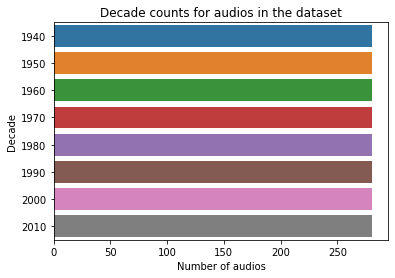

In [ ]:
sns.countplot(y='decade', data=df_train_eq)
plt.xlabel("Number of audios")
plt.ylabel("Decade")
plt.title("Decade counts for audios in the dataset"); # теперь в нашем датасете представлено одинаковое число всех десятилетий

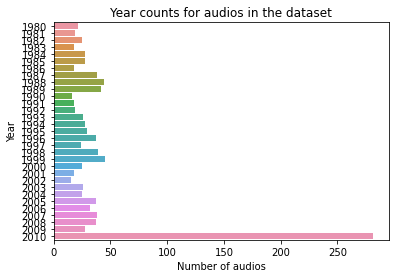

In [ ]:
data = df_train_eq[df_train_eq.decade > 1970]
sns.countplot(y=data[0], data=data)
plt.xlabel("Number of audios")
plt.ylabel("Year")
plt.title("Year counts for audios in the dataset"); # но важно отметить, что года после 2010 представлены только 2010 и 2011 в исходной выборке, и только 2010 в нашей подвыборке

3) Нормализация с помощью Standard scaler

In [ ]:
assert X_train_eq.shape[1] == 90

In [ ]:
X.dtype # в датасете только float

dtype('float64')

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_eq = scaler.fit_transform(X_train_eq)
X_train_norm = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [ ]:
# для возвращения к исходным значениям при подсчете RMSE нам нужны средние и стандартное отклонение
mean_y_train_eq = y_train_eq.mean()
std_y_train_eq = y_train_eq.std()

scaler.fit(y_train_eq.reshape(-1, 1))

y_train_eq = scaler.transform(y_train_eq.reshape(-1, 1))
y_train_norm = scaler.transform(y_train.reshape(-1, 1))
y_test = scaler.transform(y_test.reshape(-1, 1))

scale_y_train_eq = scaler.scale_ # второй путь вернуться к исходным значениям до нормализации

In [ ]:
scale_y_train_eq

array([21.75257623])

In [ ]:
pd.DataFrame(X_train_eq).describe() # смотрим на нормализованные даные

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89
count,2.248000e+03,2.248000e+03,2.248000e+03,2.248000e+03,2.248000e+03,2.248000e+03,2.248000e+03,2.248000e+03,2.248000e+03,2.248000e+03,2.248000e+03,2.248000e+03,2.248000e+03,2.248000e+03,2.248000e+03,2.248000e+03,2.248000e+03,2.248000e+03,2.248000e+03,2.248000e+03,2.248000e+03,2.248000e+03,2.248000e+03,2.248000e+03,2.248000e+03,2.248000e+03,2.248000e+03,2.248000e+03,2.248000e+03,2.248000e+03,2.248000e+03,2.248000e+03,2.248000e+03,2.248000e+03,2.248000e+03,2.248000e+03,2.248000e+03,2.248000e+03,2.248000e+03,2.248000e+03,...,2.248000e+03,2.248000e+03,2.248000e+03,2.248000e+03,2.248000e+03,2.248000e+03,2.248000e+03,2.248000e+03,2.248000e+03,2.248000e+03,2.248000e+03,2.248000e+03,2.248000e+03,2.248000e+03,2.248000e+03,2.248000e+03,2.248000e+03,2.248000e+03,2.248000e+03,2.248000e+03,2.248000e+03,2.248000e+03,2.248000e+03,2.248000e+03,2.248000e+03,2.248000e+03,2.248000e+03,2.248000e+03,2.248000e+03,2.248000e+03,2.248000e+03,2.248000e+03,2.248000e+03,2.248000e+03,2.248000e+03,2.248000e+03,2.248000e+03,2.248000e+03,2.248000e+03,2.248000e+03
mean,-1.738181e-16,-7.655008e-17,-1.522359e-16,8.494589e-17,-3.111390e-18,3.427468e-17,6.756161e-17,1.531002e-17,-8.753871e-18,4.323845e-17,-7.427827e-17,6.188209e-17,3.173124e-16,1.605082e-17,-1.059107e-16,-1.230728e-16,6.677142e-17,1.556189e-16,-1.658914e-16,-2.236867e-16,-5.235037e-17,-4.067031e-17,-2.450590e-16,8.914380e-18,-1.293943e-17,1.195169e-17,-4.444843e-18,2.197728e-18,2.212544e-17,1.995241e-17,1.486553e-17,4.247294e-17,4.607821e-17,-2.222422e-17,-4.385578e-17,1.267089e-17,4.212723e-17,-6.442244e-17,-5.926457e-18,-8.743994e-17,...,-2.647151e-17,4.069501e-17,9.652718e-17,1.733489e-17,6.006712e-18,-8.647689e-17,5.289363e-17,-3.605262e-17,-4.668320e-17,4.681901e-17,-6.884568e-17,-5.827683e-18,-9.514434e-17,-7.003097e-17,3.516365e-17,-4.711534e-17,7.543886e-17,-1.876712e-18,3.422529e-17,5.778296e-18,-5.106631e-17,-1.019845e-16,1.649531e-17,1.758182e-17,6.957414e-17,-1.185291e-18,3.684281e-17,-1.269250e-16,-1.657433e-16,2.844700e-17,-7.153728e-17,-2.084138e-17,7.971085e-17,-4.232478e-17,-3.679342e-17,-2.828649e-17,-7.408072e-19,-1.105284e-16,-4.163336e-17,-6.849997e-17
std,1.000222e+00,1.000222e+00,1.000222e+00,1.000222e+00,1.000222e+00,1.000222e+00,1.000222e+00,1.000222e+00,1.000222e+00,1.000222e+00,1.000222e+00,1.000222e+00,1.000222e+00,1.000222e+00,1.000222e+00,1.000222e+00,1.000222e+00,1.000222e+00,1.000222e+00,1.000222e+00,1.000222e+00,1.000222e+00,1.000222e+00,1.000222e+00,1.000222e+00,1.000222e+00,1.000222e+00,1.000222e+00,1.000222e+00,1.000222e+00,1.000222e+00,1.000222e+00,1.000222e+00,1.000222e+00,1.000222e+00,1.000222e+00,1.000222e+00,1.000222e+00,1.000222e+00,1.000222e+00,...,1.000222e+00,1.000222e+00,1.000222e+00,1.000222e+00,1.000222e+00,1.000222e+00,1.000222e+00,1.000222e+00,1.000222e+00,1.000222e+00,1.000222e+00,1.000222e+00,1.000222e+00,1.000222e+00,1.000222e+00,1.000222e+00,1.000222e+00,1.000222e+00,1.000222e+00,1.000222e+00,1.000222e+00,1.000222e+00,1.000222e+00,1.000222e+00,1.000222e+00,1.000222e+00,1.000222e+00,1.000222e+00,1.000222e+00,1.000222e+00,1.000222e+00,1.000222e+00,1.000222e+00,1.000222e+00,1.000222e+00,1.000222e+00,1.000222e+00,1.000222e+00,1.000222e+00,1.000222e+00
min,-4.056723e+00,-3.684944e+00,-4.135792e+00,-4.784161e+00,-3.684372e+00,-3.792417e+00,-4.262028e+00,-4.168488e+00,-6.146705e+00,-3.398347e+00,-4.883472e+00,-3.782574e+00,-1.603359e+00,-1.509412e+00,-1.465764e+00,-1.362341e+00,-1.732171e+00,-1.591180e+00,-1.775344e+00,-1.573679e+00,-1.599466e+00,-1.962204e+00,-1.517627e+00,-1.764997e+00,-6.267082e+00,-5.199639e+00,-1.109880e+01,-6.763676e+00,-7.509792e+00,-3.893215e+00,-6.593239e+00,-6.492717e+00,-4.300738e+00,-4.953168e+00,-1.202035e+01,-4.258710e+00,-7.352781e+00,-6.781651e+00,-7.751566e+00,-5.708337e+00,...,-5.324

In [ ]:
pd.DataFrame(X_test).describe() # смотрим на нормализованные даные

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89
count,5.163000e+04,5.163000e+04,5.163000e+04,5.163000e+04,5.163000e+04,5.163000e+04,5.163000e+04,5.163000e+04,5.163000e+04,5.163000e+04,5.163000e+04,5.163000e+04,5.163000e+04,5.163000e+04,5.163000e+04,5.163000e+04,5.163000e+04,5.163000e+04,5.163000e+04,5.163000e+04,5.163000e+04,5.163000e+04,5.163000e+04,5.163000e+04,5.163000e+04,5.163000e+04,5.163000e+04,5.163000e+04,5.163000e+04,5.163000e+04,5.163000e+04,5.163000e+04,5.163000e+04,5.163000e+04,5.163000e+04,5.163000e+04,5.163000e+04,5.163000e+04,5.163000e+04,5.163000e+04,...,5.163000e+04,5.163000e+04,5.163000e+04,5.163000e+04,5.163000e+04,5.163000e+04,5.163000e+04,5.163000e+04,5.163000e+04,5.163000e+04,5.163000e+04,5.163000e+04,5.163000e+04,5.163000e+04,5.163000e+04,5.163000e+04,5.163000e+04,5.163000e+04,5.163000e+04,5.163000e+04,5.163000e+04,5.163000e+04,5.163000e+04,5.163000e+04,5.163000e+04,5.163000e+04,5.163000e+04,5.163000e+04,5.163000e+04,5.163000e+04,5.163000e+04,5.163000e+04,5.163000e+04,5.163000e+04,5.163000e+04,5.163000e+04,5.163000e+04,5.163000e+04,5.163000e+04,5.163000e+04
mean,5.205211e-16,-1.836222e-16,-5.375002e-17,-1.771884e-17,-2.365379e-17,-1.007652e-17,-1.011329e-16,-7.225159e-18,4.548624e-17,3.296479e-17,-6.314165e-17,-6.630373e-17,4.859134e-17,-7.296980e-17,6.203530e-17,-2.325813e-17,-1.733393e-16,-7.282788e-17,-8.705026e-17,-3.922659e-17,-1.045347e-16,1.706213e-16,1.584095e-16,-1.698772e-16,3.984119e-17,-1.076463e-17,5.831789e-17,8.664814e-18,-4.809246e-18,-3.932712e-17,1.661813e-17,-4.155756e-17,-3.083111e-17,-1.411916e-17,1.919075e-17,5.970862e-17,-4.403476e-17,-7.868475e-17,-1.605609e-17,-2.481229e-18,...,3.215827e-17,-4.286712e-18,7.331278e-17,5.963175e-18,1.122019e-16,2.060030e-18,1.253221e-17,-4.995574e-17,1.204021e-16,1.155810e-17,-4.926117e-17,-2.534504e-17,-4.401057e-17,-2.137658e-17,-2.046053e-17,-5.993011e-17,2.250336e-17,1.355362e-17,-4.214246e-17,3.599247e-17,-8.226467e-17,-4.254672e-17,4.073291e-17,-4.386918e-17,4.062163e-17,-2.005197e-19,-3.994696e-17,-1.622220e-17,1.001875e-16,-1.158337e-17,8.070674e-17,1.785449e-16,8.522945e-17,-1.705465e-17,8.315383e-18,1.249780e-17,2.009363e-17,6.245892e-17,4.320392e-17,5.958820e-17
std,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,...,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00
min,-6.155821e+00,-5.942100e+00,-7.198908e+00,-5.593271e+00,-5.454792e+00,-3.746647e+00,-7.634118e+00,-7.026790e+00,-7.158972e+00,-5.983420e+00,-1.417578e+01,-9.981021e+00,-1.482420e+00,-1.369104e+00,-1.506629e+00,-1.325829e+00,-1.795096e+00,-1.489235e+00,-1.780011e+00,-1.581104e+00,-1.740673e+00,-1.757847e+00,-1.396519e+00,-1.877818e+00,-1.132759e+01,-1.865627e+01,-1.766211e+01,-1.343633e+01,-1.094985e+01,-1.021146e+01,-1.422773e+01,-1.288784e+01,-1.214965e+01,-1.613555e+01,-1.583586e+01,-7.608642e+00,-1.431790e+01,-1.283166e+01,-2.206922e+01,-2.096883e+01,...,-1.420

In [ ]:
pd.DataFrame(y_train_eq).describe()

,0
count,2.248000e+03
mean,-6.666277e-15
std,1.000222e+00
min,-1.785161e+00
25%,-9.231941e-01
50%,-1.525569e-02
75%,8.926827e-01
max,1.386877e+00


In [ ]:
pd.DataFrame(y_test).describe()

,0
count,51630.000000
mean,0.858009
std,0.498884
min,-2.428763
25%,0.697304
50%,1.019105
75%,1.202991
max,1.386877


4) Применим метод главных компенент:

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(.90)

# обучаем только на тренировочной выборке
pca.fit(X_train_eq)

# число компонент на выходе
n_input = pca.n_components_
n_input

51

In [ ]:
X_train_pca = pca.transform(X_train_eq)
X_test_pca = pca.transform(X_test)

In [ ]:
X_train_pca.shape

(2248, 51)

In [ ]:
X_test_pca.shape

(51630, 51)

Вы можете придерживаться любой адекватной струкуры кода, но мы советуем воспользоваться следующими сигнатурами функций. Лучше всего, если вы проверите ваши предсказания ассертом: так вы убережете себя от разных косяков, например, что вектор предсказаний состоит из всего одного числа. В любом случае, внимательно следите за тем, для каких тензоров вы считаете метрику RMSE. При случайном или намеренном введении в заблуждение проверяющие очень сильно разозлятся.

In [ ]:
import torch.nn.functional as F
from torch import nn
from torch.utils.data import TensorDataset, DataLoader

In [ ]:
# переводим в numpy arrays в тензоры
#tensor_X_train = torch.from_numpy(X_train_pca)
#tensor_X_train = torch.from_numpy(X_train_eq)
tensor_X_train = torch.from_numpy(X_train_norm)
#tensor_y_train = torch.from_numpy(y_train_eq).view(-1,1)
tensor_y_train = torch.from_numpy(y_train_norm).view(-1,1) 
#tensor_X_test = torch.from_numpy(X_test_pca)
tensor_X_test = torch.from_numpy(X_test) 
tensor_y_test = torch.from_numpy(y_test).view(-1,1)

# гиперпараметры в одном месте
'''
https://github.com/skorch-dev/skorch

from sklearn.model_selection import GridSearchCV

params = {
    'LR': [0.0001,0.0005, 0.001, 0.005, 0.01],
    'n_epochs': [10, 25, 60, 120, 200, 300]),
    'bs': [40, 60, ],

}

gs = GridSearchCV(net, params, refit=False, scoring='r2', verbose=1, cv=10)

gs.fit(X_trf, y_trf)
'''

bs = 200
n_epochs = 20
LR = 0.005

# создаем datasets и loaders
train_set = TensorDataset(tensor_X_train, tensor_y_train) 
train_loader = DataLoader(train_set, batch_size = bs, shuffle=True, worker_init_fn=set_random_seed,
    generator=g) 

test_set = TensorDataset(tensor_X_test, tensor_y_test) 
test_loader = DataLoader(test_set, batch_size = bs*2, shuffle=True, worker_init_fn=set_random_seed,
    generator=g)  

In [ ]:
# пишем RMSE loss, source: https://discuss.pytorch.org/t/rmse-loss-function/16540/3
class RMSELoss(nn.Module):
    def __init__(self, eps=1e-6):
        super().__init__()
        self.mse = nn.MSELoss()
        self.eps = eps
        
    def forward(self,yhat,y):
        loss = torch.sqrt(self.mse(yhat,y) + self.eps)
        return loss

In [ ]:
# создаем нейросеть
n_input = 90
def get_model(n_input):
    set_random_seed(13) # используем функцию для фиксации
    return torch.nn.Sequential(
    nn.Linear(n_input, 150), 
    nn.ReLU(),
    nn.Linear(150, 75),
    nn.BatchNorm1d(75),
    nn.ReLU(),
    nn.Linear(75, 25),
    nn.ReLU(),
    nn.Linear(25, 1),
    nn.ReLU()     
)

model = get_model(n_input)

criterion = RMSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [ ]:
# функция с семинара для визуализации
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython.display import clear_output

def plot_history(train_history, val_history, title='loss'):
    plt.figure()
    plt.title('{}'.format(title))
    plt.plot(train_history, label='train', zorder=1)
    
    points = np.array(val_history)
    steps = list(range(0, len(train_history) + 1, int(len(train_history) / len(val_history))))[1:]
    
    plt.scatter(steps, val_history, marker='+', s=180, c='orange', label='val', zorder=2)
    plt.xlabel('train steps')
    
    plt.legend(loc='best')
    plt.grid()

    plt.show()

In [ ]:
def train_model(model, optimizer, criterion, train_loader, n_epochs) -> torch.Tensor:
      '''
    params:
        model - torch.nn.Module to be fitted
        optimizer - model optimizer
        criterion - loss function from torch.nn
        train_loader - torch.utils.data.Dataloader with train set
        test_loader - torch.utils.data.Dataloader with test set
                      (if you wish to validate during training)
        n_epochs - number of epochs
    '''
        model.train()
        loss_fn = criterion
        loss_tensor = torch.zeros(size=(n_epochs,),
                                  dtype=torch.float64)

        for epoch in tqdm(range(n_epochs),
                          desc="Training Model",
                          unit="epochs",
                          colour="green"):
            epoch_loss = 0

            for batch in train_loader:
                optimizer.zero_grad()
                x_input, y_target = batch
                output = model(x_input.float())
                loss = loss_fn(output.float(), y_target.float())
                loss.backward()
                optimizer.step()

                epoch_loss += loss.item()

            loss_tensor[epoch] += (epoch_loss / len(train_loader))

        return loss_tensor

In [ ]:
train_model(model, optimizer, criterion, train_loader, n_epochs)

Training Model: 100%|██████████| 20/20 [02:42<00:00,  8.13s/epochs]


tensor([0.4124, 0.4001, 0.3962, 0.3932, 0.3908, 0.3884, 0.3863, 0.3845, 0.3829,
        0.3813, 0.3800, 0.3790, 0.3776, 0.3765, 0.3754, 0.3744, 0.3733, 0.3726,
        0.3717, 0.3711], dtype=torch.float64)

In [ ]:
0.3711 * scale_y_train_eq

array([8.07238104])

In [ ]:
def test(model, criterion, test_loader):
    '''
    params:
        model - torch.nn.Module to be evaluated on test set
        criterion - loss function from torch.nn
        test_loader - torch.utils.data.Dataloader with test set
    ----------
    returns:
        predicts - torch.tensor with shape (len(test_loader.dataset), ),
                   which contains predictions for test objects
    '''
    model.eval()
    loss_fn = criterion
    with torch.no_grad():
      test_features = test_loader.dataset[:,:][0]
      test_target = test_loader.dataset[:,:][1]
      predicts = model(test_features.float())

      print("loss:", loss_fn(predicts.float(), test_target.float()), "\nloss (corrected):", loss_fn(predicts.float(), test_target.float()) * scale_y_train_eq)

    return predicts

In [ ]:
test(model, criterion, test_loader)

loss: tensor(0.4096) 
loss (corrected): tensor([8.9091], dtype=torch.float64)


tensor([[1.0116],
        [1.0616],
        [1.0716],
        ...,
        [0.8473],
        [1.0324],
        [1.0144]])

In [ ]:
assert test(model, criterion, test_loader).shape[0] == y_test.shape[0]

loss: tensor(0.3692) 
loss (corrected): tensor([8.0314], dtype=torch.float64)


AssertionError: ignored

## Задание 2. (0 баллов, но при невыполнении максимум за все задание &mdash; 0 баллов)

Напишите небольшой отчет о том, как вы добились полученного качества: какие средства использовали и какие эксперименты проводили. Подробно расскажите об архитектурах и значениях гиперпараметров, а также какие метрики на тесте они показывали. Чтобы отчет был зачтен, необходимо привести хотя бы 3 эксперимента.

1) Использование PCA при подготовке данных

2) Использование выборки с одинаковым числом аудио в каждой декаде

3) Количество слоев

5) Добавление BatchNorm

6) Добавление Dropout

4) Подбор метода оптимизации и гиперпараметров: размер бэтча, lerning rate, 

In [ ]:
from skorch import NeuralNetRegressor
net = NeuralNetRegressor(Net
                         , max_epochs=100
                         , lr=0.001
                         , verbose=1)

In [ ]:
from sklearn.model_selection import GridSearchCV

params = {
    'lr': [0.001,0.005, 0.01, 0.05, 0.1, 0.2, 0.3],
    'max_epochs': list(range(500,5500, 500))
}

gs = GridSearchCV(net, params, refit=False, scoring='r2', verbose=1, cv=10)

gs.fit(X_trf, y_trf)

In [ ]:
train_loss_info = train_model(model, optimizer, criterion, train_loader, n_epochs)

plt.plot(np.arange(n_epochs), train_loss_info.eval_epoch_losses)
plt.legend()
plt.show()